# Using CNN to extract data from plots

- We'll start by making synthetic images of plots that look like "real" log plots
- Train a 5-6 layer CNN using Keras
- Return 20 inferred points from the RGB image fed. (the idea is to segment the log in chunks)
- Repeat until it works
- It uses Tensorflow 2.0 Beta 1.

TODO:
- Use OCR output to scale points extracted to physical units
- Expand the amount of points extracted (from 20 to 100s?)
- Test/Generate other types of log plots.

In [0]:
import pylab as plt
# %matplotlib inline

In [0]:
import numpy as np

In [3]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


Synthetic image generation function:

In [0]:
def gen_im(n=1):
    
    rn = np.random.uniform(low=0, high=1, size=(20,))
    # Make a random plot...
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(rn,"r")
    ax.grid()
    
    DPI = fig.get_dpi()
    fig.set_size_inches(150/float(DPI),150/float(DPI))
#     fig.set_size_inches(3,3)
    fig.canvas.draw()

    # Now we can save it to a numpy array.
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
#     data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close('all')

    return data, rn, fig.canvas.get_width_height()[::-1]

In [5]:
_,_,size = gen_im(n=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Batch image generation function:

In [0]:
def batch_gen(n=1):
    for i in range(n):
        if i==0:
            arr, vals, size = gen_im()
        else:
            tmparr, tmpvals, size = gen_im()
            arr = np.vstack((arr,tmparr))
            vals = np.vstack((vals,tmpvals))
            
    arr = arr.reshape(arr.shape[0], *size, 3)[:,:,:,:]
    
    return arr, vals

Let's start with 1000 training samples and 100 test samples

In [7]:
x_train, y_train = batch_gen(n=2000)
x_test, y_test = batch_gen(n=200)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


We reshaped the images to be squared just because it's easier. Here's how they look:

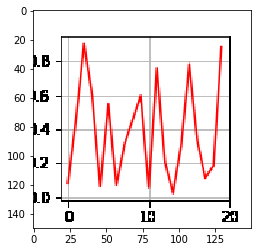

In [8]:
plt.imshow(x_train[0,:].reshape(*size,3))
plt.show()

# CNN

Let's implement CNN's until they work!

In [9]:
batch_size = 1
num_points = 20
epochs = 200

# input image dimensions
img_x, img_y = size


input_shape = (img_x, img_y, 3)


print('x_train shape:', x_train.shape)

x_train shape: (2000, 150, 150, 3)


#### Model definition

In [0]:
filter_size = 3
pool_size = 2
dropout = 0.4
lr = 0.001 # learning rate

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32, (filter_size, filter_size), input_shape=input_shape, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(pool_size, pool_size)),
    tf.keras.layers.Conv2D(64, (filter_size, filter_size), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(pool_size, pool_size)),
    tf.keras.layers.Conv2D(128, (filter_size, filter_size), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(pool_size, pool_size)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv2D(128, (filter_size, filter_size), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(pool_size, pool_size)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(num_points)

])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss='mae',
              metrics=['accuracy'])

# Train

In [12]:
model.fit(x_train, y_train,
          batch_size=200,
          epochs=400,
          verbose=1,
          )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)

Train on 2000 samples
Epoch 1/400
2000/2000 [==============================] - 7s 4ms/sample - loss: 2.4737 - accuracy: 0.0535
Epoch 2/400
2000/2000 [==============================] - 2s 927us/sample - loss: 0.3377 - accuracy: 0.0425
Epoch 3/400
2000/2000 [==============================] - 2s 928us/sample - loss: 0.3000 - accuracy: 0.0600
Epoch 4/400
2000/2000 [==============================] - 2s 933us/sample - loss: 0.2790 - accuracy: 0.0685
Epoch 5/400
2000/2000 [==============================] - 2s 940us/sample - loss: 0.2676 - accuracy: 0.0705
Epoch 6/400
2000/2000 [==============================] - 2s 934us/sample - loss: 0.2572 - accuracy: 0.0830
Epoch 7/400
2000/2000 [==============================] - 2s 933us/sample - loss: 0.2511 - accuracy: 0.0765
Epoch 8/400
2000/2000 [==============================] - 2s 939us/sample - loss: 0.2470 - accuracy: 0.1005
Epoch 9/400
2000/2000 [==============================] - 2s 942us/sample - loss: 0.2418 - accuracy: 0.0970
Epoch 10/400
2000

Previous run took ~30mins in Google Colab. It needs to be optimized for all the parameters involved (hyperopt?) and add an early stopping callback.

# Results so far...

In [13]:
model.predict(x_test[0].reshape(1,*size, 3))

array([[0.9334986 , 0.6879431 , 0.7678375 , 0.79205984, 0.5525311 ,
        0.7286248 , 0.36762157, 0.05891058, 0.2195811 , 0.75779057,
        0.16296834, 0.7055731 , 0.92373896, 0.91648966, 0.12607726,
        0.09981337, 0.29021168, 0.87546456, 0.9393277 , 0.19398329]],
      dtype=float32)

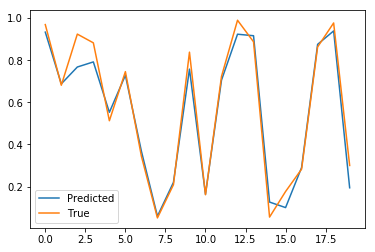

In [14]:
plt.plot(model.predict(x_test)[0], label='Predicted')
plt.plot(y_test[0], label='True')
plt.legend()
plt.show()

## We need a couple of actual image tests